# Домашнее задание 4

Это домашнее задание по материалам второго семинаров. Дедлайн по отправке - 23:55 3 марта. 

Домашнее задание выполняется в этом же Jupyter Notebook'e и присылается мне на почту: __beznosikov.an@phystech.edu__.

Решение каждой задачи необходимо поместить после её условия.

Файл должен называться: Фамилия_Имя_Optimization_HW_4

При полном запуске Вашего решения (Kernel -> Restart & Run All) все ячейки должны выполняться без ошибок. 

## Задача 1

Рассмотрим задачу минимизации:
\begin{equation}
\min_{x \in \triangle_d} f(x) = \frac{1}{2}x^T A x,
\end{equation}
где в качестве матрицы $A$ - случайная матрица (уже умеем генерировать) с $L =1000$, $\mu = 1$, а $\triangle_d$ - вероятностный симплекс:
$$
\triangle_d = \{x ~|~ x_i \geq 0, \sum_{i=1}^d x_i = 1\}.
$$

__(а)__ Для такой задачи напишите итерацию зеркального спуска с дивергенцией Брегмана, порожденной энтропийной функцией. Найдите выражение для итерации метода в явном виде (без подсчетов $\arg\min$).

In [3]:
#matrix generation, from first homework
import numpy as np 
from numpy import linalg 

def rvs(dim=3):
     random_state = np.random
     H = np.eye(dim)
     D = np.ones((dim,))
     for n in range(1, dim):
         x = random_state.normal(size=(dim-n+1,))
         D[n-1] = np.sign(x[0])
         x[0] -= D[n-1]*np.sqrt((x*x).sum())
         # Householder transformation
         Hx = (np.eye(dim-n+1) - 2.*np.outer(x, x)/(x*x).sum())
         mat = np.eye(dim)
         mat[n-1:, n-1:] = Hx
         H = np.dot(H, mat)
     D[-1] = (-1)**(1-(dim % 2))*D.prod()
     H = (D*H.T).T
     return H
    
def generate_matrix(d, m, L):  
    A = np.eye(d) 
    A[0, 0] = L
    A[1, 1] = m
    S = rvs(d) 
    A = np.dot(np.linalg.inv(S), np.dot(A, S))
    return A 

Шаг зеркального спуска c дивергенцией Брегмана, порожденной энтропийной функцией: 
    $$ x^{k + 1} =  argmin_{x \in \triangle_{d}} (\nabla f(x^{k}), x) + \sum_{i}^{d} x_{i}ln \cfrac{x_{i}}{x_{i}^{k}}$$
    
Воспользуемся теоремой ККТ: для начала запишем лагранжиан: 

$$L = (\nabla f(x^{k}), x) + \sum_{i = 1}^{d}x_{i}ln\cfrac{x_{i}}{x_{i}^{k}} - \sum_{i = 1}^{d}\lambda_{i}x_{i} + \mu(\sum_{i = 1}^{d}x_{i} - 1)$$ 

$$\cfrac{\partial L}{\partial x_{i}} = \nabla f(x_{i}^{k}) + ln \cfrac{x_{i}}{x_{i}^{k}} + x_{i}^{k} - \lambda_{i} + \mu = 0$$ 

Избавимся от $\lambda$: 
    $$\nabla f(x_{i}^{k}) + ln \cfrac{x_{i}}{x_{i}^{k}} + x_{i}^{k} + \mu \geq 0$$ 
    
Воспользуемся условием, дополняющей нежесткости:      

$$(\nabla f(x_{i}^{k}) + ln \cfrac{x_{i}}{x_{i}^{k}} + x_{i}^{k} + \mu)x_{i} = 0$$ 

Откуда можно получить, что: 

$$x_{i}^{k + 1} = x_{i} = x_{i}^{k}exp(-\mu - \nabla f(x_{i}^{k}) - x_{i}^{k})$$ 

Отметим также, что условие Слейтера выполнено для данной задачи, что найдется $x^{k} > 0$, ну значит он и есть минимум, следуя достаточному условию. 

$\mu$ найдем из суммы координат равной 1. Не сложно получить, что 

$$exp(\mu) = \sum_{i = 1}^{d}x_{i}^{k}exp(-\nabla f(x_{i}^{k}) - x_{i}^{k}))$$ 

$$\mu = \sum_{i = 1}^{d}ln(x_{i}^{k}) - \nabla f(x_{i}^{k}) - x_{i}^{k}$$

__(б)__ Реализуйте метод зеркального спуска из пункта (а). Постройте для него график сходимости по времени и по итерациям. В качестве критерия сходимости используйте:
$$
\text{gap}(x^k) = \max_{y \in \triangle_d} \langle \nabla f(x^k), x^k - y \rangle,
$$
или усредненную версию $\frac{1}{k} \sum_{i=1}^k \text{gap}(x^i)$. Найдите выражение в явном виде для подсчета $\text{gap}(x^k)$.

Пользуясь тем, что мы работаем на вероятностном симплексе, мы можем, не записывая ККТ, сделать вывод, что: 

$$gap(x^{k}) = \nabla f^{T}(x^{k})x^{k} - min_{i}(\nabla f(x_{i}^{k}))$$

In [166]:
import math  
eps = 1e-6
class MirrorDescent: 
    def __init__(self, d, max_iter = 10000): 
        self.d = d 
        self.A = generate_matrix(self.d, 1, 1000) 
        self.x = None 
        self.gap_history = []  
        self.max_iter = max_iter
        
    def f(self): 
        return 1/2 * np.dot(x.T, np.dot(A, x))
        
    def grad_f(self): 
        return 1/2 * np.dot((self.A.T + self.A), self.x)
    
    def fit(self):  
        self.x = np.random.normal(loc=1, size=(self.d,))  
        mu = 0 
        for i in range(self.max_iter): 
            g = self.grad_f() 
            
            for i in range(self.d):  
                arg = np.clip(-g[i] - self.x[i], None, 20)
                mu += self.x[i] * np.exp(arg)   
            mu = np.clip(mu, eps, None) 
            mu = np.log(mu)
            
            arg = np.clip(-mu - g - self.x, None, 20)
            self.x = self.x * np.exp(arg)
            self.gap_history.append(np.dot(g.T, self.x) - np.min(g)) 

In [167]:
md = MirrorDescent(100) 
md.fit()

/tmp/ipykernel_269602/638909306.py:25: RuntimeWarning: overflow encountered in double_scalars
  mu += self.x[i] * np.exp(arg)
/tmp/ipykernel_269602/638909306.py:25: RuntimeWarning: invalid value encountered in double_scalars
  mu += self.x[i] * np.exp(arg)


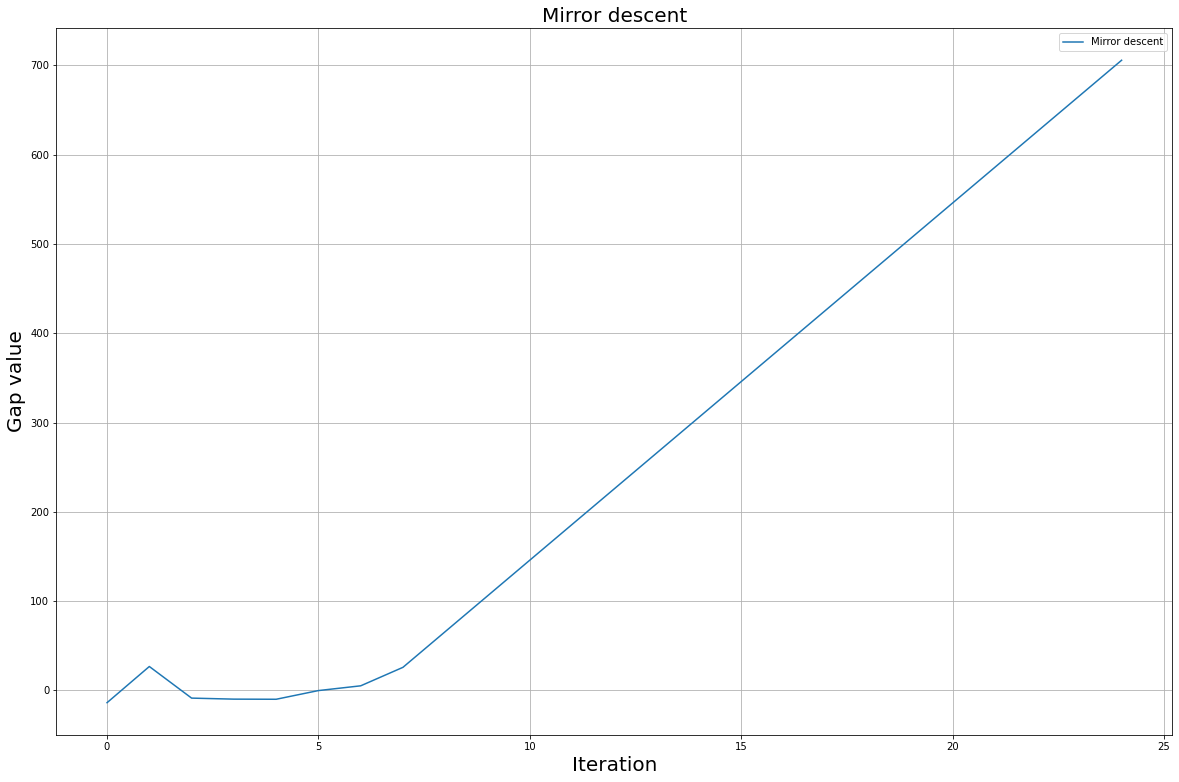

In [168]:
import matplotlib.pyplot as plt  
plt.figure(figsize=(20, 13)) 
plt.title('Mirror descent', fontsize=20)
result = np.clip(md.gap_history, eps, None)
plt.plot(range(10000), np.log(result), label='Mirror descent')  
plt.xlabel('Iteration', fontsize=20)  
plt.ylabel('Gap value', fontsize=20)
plt.legend()
plt.grid() 
plt.show()

__(в)__ Для этой же задачи напишите итерацию метода Франка-Вульфа. Реализуйте этот метод. Постройте для него график сходимости по времени и по итерациям. Добавьте эти графики к графикам для зеркального спуска. Сделайте вывод.

In [ ]:
#ответ

__Бонусные пункты__

__(г)__ Реализуйте метод градиентного спуска для нашей задачи. Для этого найдите в Интернете алгоритм евклидовой проекции на вероятностный симплекс. Постройте для градиентного спуска с евклидовой проекцией график сходимости по времени и по итерациям. Добавьте эти графики к графикам для зеркального спуска и метода Франка-Вульфа. Сделайте вывод.

In [ ]:
#ответ

__(д)__ В [работе](https://sci-hub.ru/https://doi.org/10.1137/140992382) представлена ускоренная версия метода Франка-Вульфа (Алгоритм 2 для сильно выпуклой задачи). Он лучше с точки зрения теоретической сходимости по числу вызовов градиента. Реализуйте Алгоритм 2 для нашей задачи. Постройте график сходимости по времени и по количеству подсчетов $\nabla f$ (для предыдущих методов это было эквивалетно итерациям). Добавьте эти графики к графикам для остальных методов которые были получены выше. Сделайте вывод.

In [ ]:
#ответ